# Merge Select Batches Together

Merge batches 5, 6, and 7 together.
These batches contain 5 total plates that all have roughly the same platemap.

There are 8 unique samples measured on each plate in 3 replicates each, plus one sample measured on each plate in 9 replicates.
The 8 samples are: `BZ001`, `BZ008`, `BZ017`, `BZ018`, `WT002`, `WT008`, `WT009`, `WT011` and `WT_parental`.
All samples have been treated with both DMSO (control) and 7nm Bortezomib.

In [1]:
import os
import numpy as np
import pandas as pd
import umap
import plotnine as gg

from pycytominer import feature_select
from pycytominer import write_gct
from pycytominer.cyto_utils import infer_cp_features
from pycytominer import audit
from pycytominer import aggregate

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline

In [4]:
def load_data(batch,
              profile_dir="profiles",
              file_select="normalized_variable_selected"):
    batch_dir = os.path.join(profile_dir, batch)

    backend_folders = os.listdir(batch_dir)
    plate_files = [
        os.path.join(batch_dir, x, "{}_{}.csv".format(x, file_select))
        for x in backend_folders if ".DS_Store" not in x
    ]
    
    plate_dfs = []
    for plate_file in plate_files:
        plate_dfs.append(pd.read_csv(plate_file))
        
    plate_df = pd.concat(plate_dfs, axis="rows")
    plate_df = plate_df.assign(Metadata_batch=batch)
    
    # Reorder columns
    meta_col_bool = plate_df.columns.str.contains("Metadata_")
    meta_cols = plate_df.columns[meta_col_bool].tolist()
    cp_cols =  plate_df.columns[~meta_col_bool].tolist()
    col_order = meta_cols + cp_cols
    
    return plate_df.loc[:, col_order]

In [5]:
profile_dir = os.path.join("..", "1.process-profiles", "profiles")

In [6]:
# Only use certain batches
# These batches have the same platemap
use_batches = ["2019_11_19_Batch5", "2019_11_20_Batch6", "2019_11_22_Batch7"]

In [7]:
# Merge batches
batch_df = list()
for batch in use_batches:
    data = load_data(batch, profile_dir=profile_dir, file_select="normalized")
    batch_df.append(data)
    
batch_df = pd.concat(batch_df, axis="rows")

# Add column of clonal resistance
batch_df = batch_df.assign(Metadata_clone_type="resistant")
batch_df.loc[batch_df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "wildtype"

meta_col_bool = batch_df.columns.str.contains("Metadata_")
meta_cols = batch_df.columns[meta_col_bool].tolist()
cp_cols =  batch_df.columns[~meta_col_bool].tolist()
col_order = meta_cols + cp_cols
batch_df = batch_df.loc[:, col_order]

print(batch_df.shape)
batch_df.head()

(300, 3539)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_batch,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,217755,B02,217755,217755,B02,BZ017,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,1.495664,1.505985,1.515682,1.607442,1.507616,1.685768,1.502416,1.496784,1.511082,1.493042
1,217755,B03,217755,217755,B03,WT002,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,-0.868991,-0.884266,-0.971063,-1.022792,-0.984642,-1.030670,-0.858726,-0.861603,-0.862058,-0.859742
2,217755,B04,217755,217755,B04,WT008,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,1.682980,1.708826,1.734508,1.876558,1.736488,1.860050,1.678591,1.671275,1.685215,1.676021
3,217755,B05,217755,217755,B05,WT009,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,0.540509,0.539987,0.551591,0.536016,0.558845,0.551131,0.529142,0.532430,0.528581,0.533432
4,217755,B06,217755,217755,B06,BZ018,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,3.508515,3.587259,3.690211,3.922416,3.691525,4.018119,3.489660,3.488300,3.499609,3.492558


In [8]:
pd.crosstab(batch_df.Metadata_clone_number, batch_df.Metadata_treatment)

Metadata_treatment,DMSO,bortezomib
Metadata_clone_number,,
BZ001,15,15
BZ008,15,15
BZ017,15,15
BZ018,15,15
WT002,15,15
WT008,15,15
WT009,15,15
WT011,15,15
WT_parental,45,15


In [9]:
# Apply feature selection using all features
batch_feature_select_df = feature_select(
    profiles=batch_df,
    operation="drop_na_columns"
)

ops = [
    "variance_threshold",
    "correlation_threshold",
    "blacklist",
    "drop_outliers"
]

batch_feature_select_df = feature_select(
    profiles=batch_feature_select_df,
    operation=ops
)

In [10]:
print(batch_feature_select_df.shape)
batch_feature_select_df.head()

(300, 303)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_batch,...,Nuclei_Texture_Correlation_Mito_20_03,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_Entropy_AGP_20_03,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_InfoMeas1_DNA_10_01,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InfoMeas2_ER_20_03,Nuclei_Texture_SumAverage_DNA_20_03
0,217755,B02,217755,217755,B02,BZ017,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,0.886984,0.088921,0.678163,2.019547,0.681410,-0.764783,0.355471,-0.326579,-0.499605,-2.213941
1,217755,B03,217755,217755,B03,WT002,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,1.017529,-1.216818,-0.910930,0.279458,-1.647074,-1.266357,1.412051,1.434398,-2.160395,-0.935830
2,217755,B04,217755,217755,B04,WT008,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,-1.273976,1.524910,0.237746,-0.462788,1.003188,0.243853,-1.767389,-0.987268,1.374053,0.562175
3,217755,B05,217755,217755,B05,WT009,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,0.266692,0.792911,1.265980,0.903515,0.408799,0.397518,0.790918,-1.114415,0.782769,-0.368751
4,217755,B06,217755,217755,B06,BZ018,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,...,-1.161647,2.650401,1.387919,0.674833,2.071789,0.726274,-2.533400,-2.842899,2.077059,0.948588


In [11]:
output_real_file = os.path.join("data", "core_batch_profiles.tsv")
batch_feature_select_df.to_csv(output_real_file, sep="\t", index=False)

# Generate consensus profiles by well

In [12]:
consensus_well_df = (
    aggregate(batch_feature_select_df,
              strata="Metadata_well_position",
              operation="median")
)

consensus_well_df = (
    batch_feature_select_df.loc[:,
                                [
                                    "Metadata_well_position",
                                    "Metadata_clone_number",
                                    "Metadata_clone_type",
                                    "Metadata_treatment"
                                ]
                               ]
    .merge(
        consensus_well_df,
        on="Metadata_well_position"
    )
    .drop_duplicates()
    .reset_index(drop=True)
)

consensus_well_df.head()

,Metadata_well_position,Metadata_clone_number,Metadata_clone_type,Metadata_treatment,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,...,Nuclei_Texture_Correlation_Mito_20_03,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_Entropy_AGP_20_03,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_InfoMeas1_DNA_10_01,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InfoMeas2_ER_20_03,Nuclei_Texture_SumAverage_DNA_20_03
0,B02,BZ017,resistant,DMSO,0.907120,-1.618270,-1.362726,-0.168294,-0.052491,-0.577161,...,0.572758,0.088921,0.766364,1.870088,0.392409,-0.764783,1.226796,-0.536973,-0.317823,-2.213941
1,B03,WT002,wildtype,DMSO,0.640873,-0.492774,-0.974822,-1.024304,1.426863,-1.655838,...,1.136538,-1.216818,-0.430124,0.408297,-0.681949,-1.249313,1.698928,1.423683,-1.858054,-1.463515
2,B04,WT008,wildtype,DMSO,-2.445335,0.267876,1.144923,1.553118,0.500036,1.292939,...,-0.847013,0.727207,0.171752,-0.462788,-0.089504,-0.306618,-0.005545,-0.509860,0.842073,-0.282052
3,B05,WT009,wildtype,DMSO,-0.670784,-0.508280,-0.073713,0.062892,-0.842921,0.911885,...,0.313697,0.172735,1.229515,1.236879,0.854203,0.257529,0.689201,-0.703986,0.782769,-0.641652
4,B06,BZ018,resistant,DMSO,0.973302,0.826655,0.261813,0.529634,-0.125091,2.015026,...,-0.796281,1.784965,1.513046,0.674833,1.185346,-0.323654,-1.159498,-2.670384,0.767610,-0.510280


## Two methods to visualize if batch effect correction is required

In [13]:
# Step 1: Output GCT file
output_file = os.path.join("data", "core_batch.gct")
write_gct(
    profiles=batch_feature_select_df,
    output_file=output_file
)

# Step 1: Output GCT file
output_file = os.path.join("data", "core_batch_well_collapsed.gct")
write_gct(
    profiles=consensus_well_df,
    output_file=output_file
)

In [14]:
# Step 2: Apply UMAP
cp_features = infer_cp_features(batch_feature_select_df)

reducer = umap.UMAP(random_state=1234, n_components=2)

metadata_df = batch_feature_select_df.drop(cp_features, axis="columns").reset_index(drop=True)

real_embedding_df = pd.DataFrame(
    reducer.fit_transform(batch_feature_select_df.loc[:, cp_features]),
    columns=["umap_x", "umap_y"]
).reset_index(drop=True)

real_embedding_df = (
    metadata_df
    .merge(real_embedding_df,
           left_index=True,
           right_index=True)
)

print(real_embedding_df.shape)
real_embedding_df.head()

/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/umap/umap_.py", line 329:
@numba.jit()
def fuzzy_simplicial_s

(300, 13)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_batch,Metadata_clone_type,umap_x,umap_y
0,217755,B02,217755,217755,B02,BZ017,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,resistant,4.538677,3.443873
1,217755,B03,217755,217755,B03,WT002,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,wildtype,2.233128,5.008710
2,217755,B04,217755,217755,B04,WT008,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,wildtype,1.415387,2.254394
3,217755,B05,217755,217755,B05,WT009,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,wildtype,3.630352,1.621999
4,217755,B06,217755,217755,B06,BZ018,217755,20191119-TH-WTMUT-4h,DMSO,2019_11_19_Batch5,resistant,0.432097,0.456783


In [15]:
output_real_file = os.path.join("data", "core_batch_umap.tsv")
real_embedding_df.to_csv(output_real_file, sep="\t", index=False)

In [16]:
reducer = umap.UMAP(random_state=1234, n_components=2)

metadata_df = consensus_well_df.drop(cp_features, axis="columns").reset_index(drop=True)

real_well_embedding_df = pd.DataFrame(
    reducer.fit_transform(consensus_well_df.loc[:, cp_features]),
    columns=["umap_x", "umap_y"]
).reset_index(drop=True)

real_well_embedding_df = (
    metadata_df
    .merge(real_well_embedding_df,
           left_index=True,
           right_index=True)
)

print(real_well_embedding_df.shape)
real_well_embedding_df.head()

(84, 6)


,Metadata_well_position,Metadata_clone_number,Metadata_clone_type,Metadata_treatment,umap_x,umap_y
0,B02,BZ017,resistant,DMSO,4.856882,-3.470803
1,B03,WT002,wildtype,DMSO,2.837630,-4.224977
2,B04,WT008,wildtype,DMSO,1.916886,-4.118892
3,B05,WT009,wildtype,DMSO,6.350425,-3.391685
4,B06,BZ018,resistant,DMSO,5.995040,-1.668441


In [17]:
output_real_file = os.path.join("data", "core_batch_well_collapsed_umap.tsv")
real_well_embedding_df.to_csv(output_real_file, sep="\t", index=False)

## Visualize UMAP

/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 4 x 3 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/core_batch_umap_batch.png
  warn('Filename: {}'.format(filename))


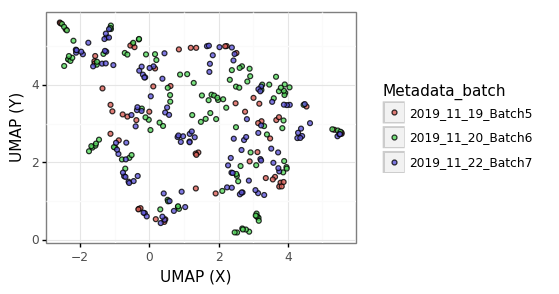

<ggplot: (-9223372036541565692)>

In [18]:
umap_batch_gg = (
    gg.ggplot(real_embedding_df, gg.aes(x="umap_x", y="umap_y")) +
    gg.geom_point(gg.aes(fill="Metadata_batch"), color='black', alpha=0.8) +
    gg.theme_bw() +
    gg.xlab("UMAP (X)") +
    gg.ylab("UMAP (Y)")
)

out_file = os.path.join("figures", "core_batch_umap_batch.png")
umap_batch_gg.save(out_file, width = 4, height = 3, dpi = 400)

umap_batch_gg

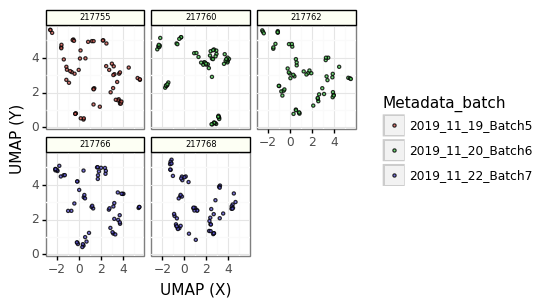

<ggplot: (-9223372036540607067)>

In [19]:
umap_batch_facet_gg = (
    gg.ggplot(real_embedding_df, gg.aes(x="umap_x", y="umap_y")) +
    gg.geom_point(gg.aes(fill="Metadata_batch"), color='black', alpha=0.8, size=0.8) +
    gg.theme_bw() +
    gg.xlab("UMAP (X)") +
    gg.ylab("UMAP (Y)") +
    gg.facet_wrap("~Metadata_plate_ID") +
    gg.theme(
            strip_text=gg.element_text(size=6, color="black"),
            strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
        )
)

out_file = os.path.join("figures", "core_batch_umap_batch_facet.png")
umap_batch_facet_gg.save(out_file, width=4, height=3, dpi=400, verbose=False)

umap_batch_facet_gg

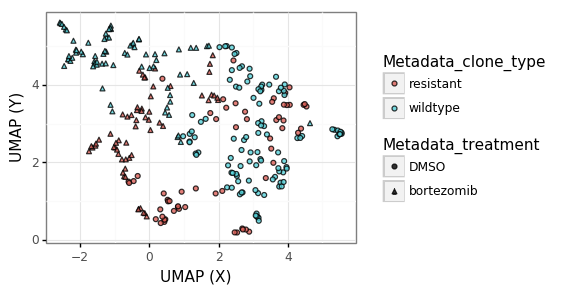

<ggplot: (-9223372036540578637)>

In [20]:
umap_resistant_type_gg = (
    gg.ggplot(real_embedding_df, gg.aes(x="umap_x", y="umap_y")) +
    gg.geom_point(gg.aes(fill="Metadata_clone_type", shape="Metadata_treatment"),
                  color='black', alpha=0.8) +
    gg.theme_bw() +
    gg.xlab("UMAP (X)") +
    gg.ylab("UMAP (Y)")
)

out_file = os.path.join("figures", "core_batch_umap_resistant_type.png")
umap_resistant_type_gg.save(out_file, width=4, height=3, dpi=400, verbose=False)

umap_resistant_type_gg

## Visualize Consensus Treatments across Wells

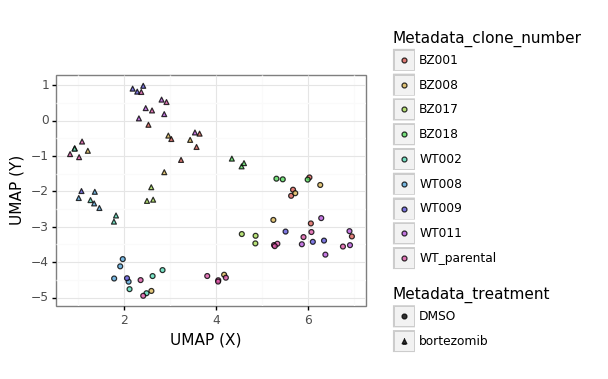

<ggplot: (-9223372036540799400)>

In [21]:
umap_well_embedding_gg = (
    gg.ggplot(real_well_embedding_df, gg.aes(x="umap_x", y="umap_y")) +
    gg.geom_point(gg.aes(fill="Metadata_clone_number", shape="Metadata_treatment"),
                  color='black', alpha=0.8) +
    gg.theme_bw() +
    gg.xlab("UMAP (X)") +
    gg.ylab("UMAP (Y)")
)

out_file = os.path.join("figures", "core_batch_umap_well_sample.png")
umap_well_embedding_gg.save(out_file, width=4, height=3, dpi=400, verbose=False)

umap_well_embedding_gg